In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import array
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import losses
from tensorflow.keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
from upbitpy import Upbitpy
import time
import datetime
class Upbit(Upbitpy):
    def __init__(self):
        super().__init__()
        # self.__upbit = Upbitpy()
        self.__krw_markets = self.__get_krw_markets()

    def __get_krw_markets(self):
        krw_markets = dict()
        all_markets = self.get_market_all()
        for market in all_markets:
            if market['market'].startswith('KRW-'):
                krw_markets[market['market']] = market
        # print(krw_markets)
        return krw_markets

    def get_15minutes_candle(self, market):
        """
        주어진 코인명에 대하여 15분 봉의 200개 캔들을 조회
        :param market: 마켓 네임
        :return: 데이터 프레임 columns={"opening_price": "open", "high_price": "high", "low_price": "low", "trade_price": "close"})
        """
        if market not in self.__krw_markets.keys():
            return None
        candles = self.get_minutes_candles(15, market, count=1)
        dt_list = [datetime.datetime.strptime(x['candle_date_time_kst'], "%Y-%m-%dT%H:%M:%S") for x in candles]
        df = pd.DataFrame(candles, columns=['opening_price', 'high_price', 'low_price', 'trade_price',
                                            'candle_acc_trade_volume'], index=dt_list)
        df = df.rename(
            columns={"opening_price": "open", "high_price": "high", "low_price": "low", "trade_price": "close",
                     "candle_acc_trade_volume": "volume"})
        # print(candles, type(candles))
        return df

    def get_1hour_candle(self, market):
        """
        주어진 코인명에 대하여 1시 봉의 1개 캔들을 조회
        :param market: 마켓 네임
        :return: 데이터 프레임 columns={"opening_price": "open", "high_price": "high", "low_price": "low", "trade_price": "close"})
        """
        if market not in self.__krw_markets.keys():
            return None
        candles = self.get_minutes_candles(60, market, count=1)
        df = pd.DataFrame(candles, columns=['opening_price', 'high_price', 'low_price', 'trade_price',
                                            'candle_acc_trade_volume'],
                          index=[datetime.datetime.strptime(x['candle_date_time_kst'], "%Y-%m-%dT%H:%M:%S") for x in
                                 candles])
        df = df.rename(
            columns={"opening_price": "open", "high_price": "high", "low_price": "low", "trade_price": "close",
                     "candle_acc_trade_volume": "volume"})
        # print(candles, type(candles))
        return df

    def get_current_price(self, market):
        cp = self.get_ticker(market)
        # print(cp)
        return cp

    def get_hour_candles(self, market):
        if market not in self.__krw_markets.keys():
            return None
        candles = self.get_minutes_candles(15, market, count=60)
        # print(candles)
        return candles

    def get_currency_list(self):
        a = self.get_market_all()

    def get_2200mincandles(self, market, ticker):
        """

        :param market: String
        :return: DataFrame
        """
        now = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
        candles = self.get_minutes_candles(ticker, market=market, to=now, count=200)
        time.sleep(1)
        for _ in range(5):
            for _ in range(10):
                new = time.strftime('%Y-%m-%dT%H:%M:%S+09:00',
                                    time.strptime(candles[len(candles) - 1]['candle_date_time_kst'], '%Y-%m-%dT%H:%M:%S'))
                candles += self.get_minutes_candles(ticker, market=market, to=new, count=200)
            time.sleep(1)

        # print(len(candles))
        df = pd.DataFrame(candles, columns=['opening_price', 'high_price', 'low_price', 'trade_price',
                                            'candle_acc_trade_volume'],
                          index=[datetime.datetime.strptime(x['candle_date_time_kst'], "%Y-%m-%dT%H:%M:%S") for x in
                                 candles]).sort_index()
        df = df.rename(
            columns={"opening_price": "open", "high_price": "high", "low_price": "low", "trade_price": "close",
                     "candle_acc_trade_volume": "volume"})

        return df

name = 'KRW-BTC'
upbit = Upbit()
data30 = upbit.get_2200mincandles(name,30)
data60 = upbit.get_2200mincandles(name,60)
data240 = upbit.get_2200mincandles(name,240)

data30.to_csv(f'{name}30.csv', index=True, encoding='UTF-8')
data60.to_csv(f'{name}60.csv', index=True, encoding='UTF-8')
data240.to_csv(f'{name}240.csv', index=True, encoding='UTF-8')
data30.head()
data60.head()
data240.head()

## MFI 구하기
def cal_mfi(df):
    df['price_avg'] = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = df['price_avg'] * df['Volume']
    diff_grad = np.diff(df['price_avg'])
    diff_grad = np.insert(diff_grad, 0, 0)
    pf = []
    nf = []
    for i in range(0, len(diff_grad)):
        if diff_grad[i] > 0:
            pf.append(money_flow[i - 1])
            nf.append(0)
        elif diff_grad[i] < 0:
            nf.append(money_flow[i - 1])
            pf.append(0)
        else:
            pf.append(0)
            nf.append(0)
    period = 14
    mfi = [np.nan for _ in range(period - 1)]
    for i in range(period - 1, len(df)):
        pos_mf = sum(pf[i - period + 1:i + 1])
        nag_mf = sum(nf[i - period + 1:i + 1])
        mfi.append(pos_mf / (nag_mf + pos_mf)*100)
    df['MFI'] = mfi
    df = df.drop(['price_avg'], axis=1)
    return df

def cal_geomean(data,period):
    data['return'] = ((data['Close']- data['Open'])/ data['Open'])
    geomean = [np.nan for _ in range(period-1)]
    for i in range(period-1, len(data)):
        proj = np.array((data['return'][i-period+1:i+1])+1)
        geomean.append((proj.prod()**(1.0/period))-1)
    data[f'geomean{period}'] = geomean
    return data

def add_indicator(filename):
    df = pd.read_csv(filename, delimiter=',')
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index(['Time'])
    df.iloc[:, 2:6].astype('float')
    # EMA
    df['EMA5'] = df.iloc[:, [4]].ewm(span=5, adjust=False).mean()
    df['EMA10'] = df.iloc[:, [4]].ewm(span=10, adjust=False).mean()
    df['EMA20'] = df.iloc[:, [4]].ewm(span=20, adjust=False).mean()
    df['EMA60'] = df.iloc[:, [4]].ewm(span=60, adjust=False).mean()
    # MACD & Signal
    df['MACD'] = df.iloc[:, [4]].ewm(span=12, adjust=False).mean() - df.iloc[:, [4]].ewm(span=26, adjust=False).mean()
    df['MACDsignal'] = df.iloc[:, [10]].ewm(span=9, adjust=False).mean()
    df['MACD-S'] = df['MACD'] - df['MACDsignal']
    # MFI
    df = cal_mfi(df)
    # per
    df = cal_geomean(df,2)
    df = cal_geomean(df,7)
    df = cal_geomean(df,12)
    print(df)
    df[200:].to_csv(filename, index=False, encoding='utf-8', header=True)
    print(df.head())
add_indicator(f'{name}30.csv')
add_indicator(f'{name}60.csv')
add_indicator(f'{name}240.csv')

data30 = pd.read_csv(f'{name}30.csv', delimiter=',',index_col='Time')
data60 = pd.read_csv(f'{name}60.csv', delimiter=',',index_col='Time')
data240 = pd.read_csv(f'{name}240.csv', delimiter=',',index_col='Time')


def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def inverse_scale(data, minmax):
    tmp = pd.DataFrame(data)
    for column in tmp.columns:
        mins, maxs = minmax[column][0], minmax[column][1]
        tmp[column] = tmp[column] * (maxs - mins) + mins

    return tmp

def normalize_data(dataset):
    cols = dataset.columns.tolist()
    col_name = [0] * len(cols)
    for i in range(len(cols)):
        col_name[i] = i
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    #     print(dtypes, minmax)
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])

    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values

    #     print(dataset)
    #     dataset[column] = values
    return dataset, minmax

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def draw_result(model,n_features,minmax):
    fig = plt.figure(figsize=(20, 15))
    chart = fig.add_subplot(2, 2, 1)
    ## summarize history for accuracy
    chart.plot(model.history['accuracy'])
    chart.plot(model.history['val_accuracy'])
    chart.set_title('model accuracy')
    chart.set_ylabel('accuracy')
    chart.set_xlabel('epoch')
    chart.legend(['train', 'valid'], loc='upper left')
    ## summarize history for loss
    chart = fig.add_subplot(2, 2, 2)
    chart.plot(model.history['loss'])
    chart.plot(model.history['val_loss'])
    chart.set_title('model loss(MSE)')
    chart.set_ylabel('MSE')
    chart.set_xlabel('epoch')
    chart.legend(['train', 'valid'], loc='upper left')
    ## summarize history for mae
    chart = fig.add_subplot(2, 2, 3)
    chart.plot(model.history['mae'])
    chart.plot(model.history['val_mae'])
    chart.set_title('model MAE')
    chart.set_ylabel('MAE')
    chart.set_xlabel('epoch')
    chart.legend(['train', 'valid'], loc='upper left')
    ## summarize history for rmse
    chart = fig.add_subplot(2, 2, 4)
    chart.plot(model.history['rmse'])
    chart.plot(model.history['val_rmse'])
    chart.set_title('model RMSE')
    chart.set_ylabel('RMSE')
    chart.set_xlabel('epoch')
    chart.legend(['train', 'valid'], loc='upper left')

    p_index = n_features

    pred_train = pd.DataFrame((model.model.predict(X_train) * (minmax[p_index][1] - minmax[p_index][0])) + minmax[p_index][0])
    y_trains = pd.DataFrame(y_train * (minmax[p_index][1] - minmax[p_index][0]) + minmax[p_index][0])

    pred_valid = pd.DataFrame((model.model.predict(X_valid) * (minmax[p_index][1] - minmax[p_index][0])) + minmax[p_index][0])
    y_valids = pd.DataFrame(y_valid * (minmax[p_index][1] - minmax[p_index][0]) + minmax[p_index][0])

    pred_test = pd.DataFrame((model.model.predict(X_test) * (minmax[p_index][1] - minmax[p_index][0])) + minmax[p_index][0])
    y_tests = pd.DataFrame(y_test * (minmax[p_index][1] - minmax[p_index][0]) + minmax[p_index][0])

    fig = plt.figure(figsize=(20, 15))
    chart = fig.add_subplot(3, 1, 1)
    chart.plot(pred_train[1][3500:], 'red', label='train_prediction')
    chart.plot(y_trains[1][3500:], 'g', label='train_truth')
    chart.legend(loc='best')
    chart = fig.add_subplot(3, 1, 2)
    chart.plot(pred_valid[1][3500:], 'red', label='valid_prediction')
    chart.plot(y_valids[1][3500:], 'g', label='valid_truth')
    chart.legend(loc='best')
    chart = fig.add_subplot(3, 1, 3)
    chart.plot(pred_test[1][800:1000], 'red', label='test_prediction')
    chart.plot(y_tests[1][800:1000], 'g', label='test_truth')
    chart.legend(loc='best')
    test_mse = losses.mean_squared_error(y_tests, pred_test).numpy()
    test_rmse = rmse(y_tests,pred_test).numpy()
    test_mae = losses.mean_absolute_error(y_tests, pred_test).numpy()
    print(f'        \t|      max\t|      min\t|      avg\t')
    print(f'valid MSE \t|{max(model.history["val_loss"]):.8f}\t|{min(model.history["val_loss"]):.8f}\t|{np.average(model.history["val_loss"]):.8f}')
    print(f'test MSE \t|{max(test_mse):.8f}\t|{min(test_mse):.8f}\t|{np.average(test_mse):.8f}')
    print(f'valid RMSE \t|{max(model.history["val_rmse"]):.8f}\t|{min(model.history["val_rmse"]):.8f}\t|{np.average(model.history["val_rmse"]):.8f}')
    print(f'test RMSE \t|{max(test_rmse):.8f}\t|{min(test_rmse):.8f}\t|{np.average(test_rmse):.8f}')
    print(f'valid MAE \t|{max(model.history["val_mae"]):.8f}\t|{min(model.history["val_mae"]):.8f}\t|{np.average(model.history["val_mae"]):.8f}')
    print(f'test MAE \t|{max(test_mae):.8f}\t|{min(test_mae):.8f}\t|{np.average(test_mae):.8f}')


                      Time        Open        High         Low       Close  \
0      2021-04-03 18:00:00  74243000.0  74555000.0  74000000.0  74127000.0   
1      2021-04-03 18:30:00  74132000.0  74800000.0  74100000.0  74761000.0   
2      2021-04-03 19:00:00  74800000.0  75101000.0  74571000.0  74943000.0   
3      2021-04-03 19:30:00  74944000.0  75047000.0  74838000.0  74865000.0   
4      2021-04-03 20:00:00  74863000.0  75080000.0  74794000.0  74963000.0   
...                    ...         ...         ...         ...         ...   
10195  2021-11-02 14:00:00  72670000.0  72700000.0  72503000.0  72599000.0   
10196  2021-11-02 14:30:00  72600000.0  72985000.0  72600000.0  72941000.0   
10197  2021-11-02 15:00:00  72950000.0  73096000.0  72603000.0  72755000.0   
10198  2021-11-02 15:30:00  72764000.0  72991000.0  72752000.0  72972000.0   
10199  2021-11-02 16:00:00  72972000.0  72997000.0  72964000.0  72964000.0   

           Volume          EMA5         EMA10         EMA20    

In [27]:
data = data60
period = 5
dataDecomposition = seasonal_decompose(data['Close'], 'multiplicative', period = period, extrapolate_trend=1)
data['seasonal'] = dataDecomposition.seasonal
data['trend'] = dataDecomposition.trend # data['Close'].ewm(span=5, adjust=False).mean()
data['detrend'] = dataDecomposition.resid # data['Close']/data['trend']/data['seasonal'] # dataDecomposition.resid

data = data[['Volume','detrend', 'seasonal','Close','return']]
data.columns = [['Volume','detrend', 'seasonal','Close','Change']]

dataset, minmax = normalize_data(data)
# choose a number of time steps
n_steps_in, n_steps_out = 20, 2
dataset = dataset.to_numpy()
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

train_len = int(len(X) * 0.4)
valid_len = int(len(X) * 0.4)
test_len = int(len(X) - train_len - valid_len)
print(train_len, valid_len, test_len, train_len + valid_len + test_len, len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_valid, y_valid = X[train_len:train_len + valid_len], y[train_len:train_len + valid_len]
X_test, y_test = X[-test_len:], y[-test_len:]
print(len(X_train), len(X_valid), len(X_test))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# [:0.5] [0.5:0.4] [-0.1]
print('n_steps ', n_steps_in, 'n_features', n_features)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', rmse])

model.summary()

3992 3992 1996 9980 9980
3992 3992 1996
n_steps  20 n_features 4
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 14, 64)            1856      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 10, 128)           41088     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 4, 128)            32896     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 1, 32)             8224      
_______________________________________________________

In [25]:
# fit model
history0 = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        TensorBoard(log_dir="logs/fit/" + str(n_features)+' features '+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
                    ],
)

63/63 [==============================] - 1s 10ms/step - loss: 4.0684e-04 - accuracy: 0.7796 - mae: 0.0149 - rmse: 0.0167

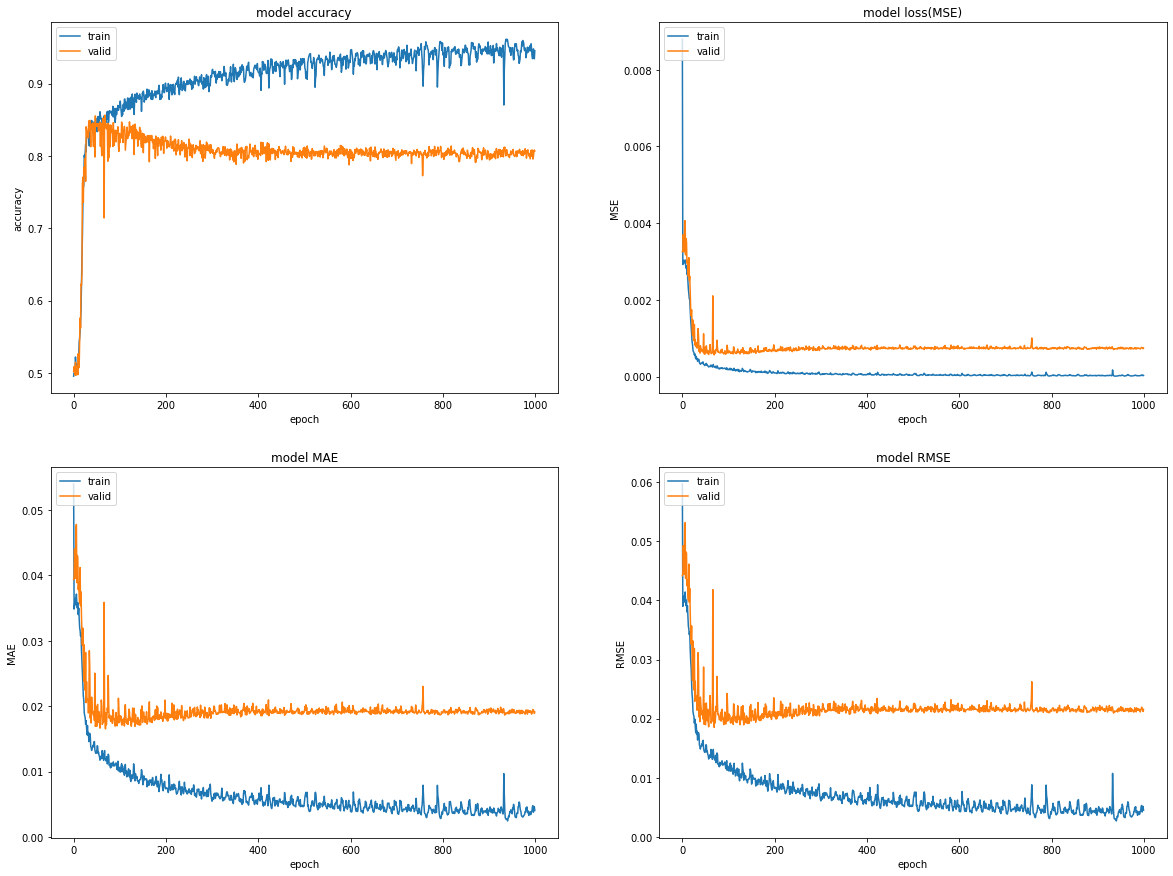

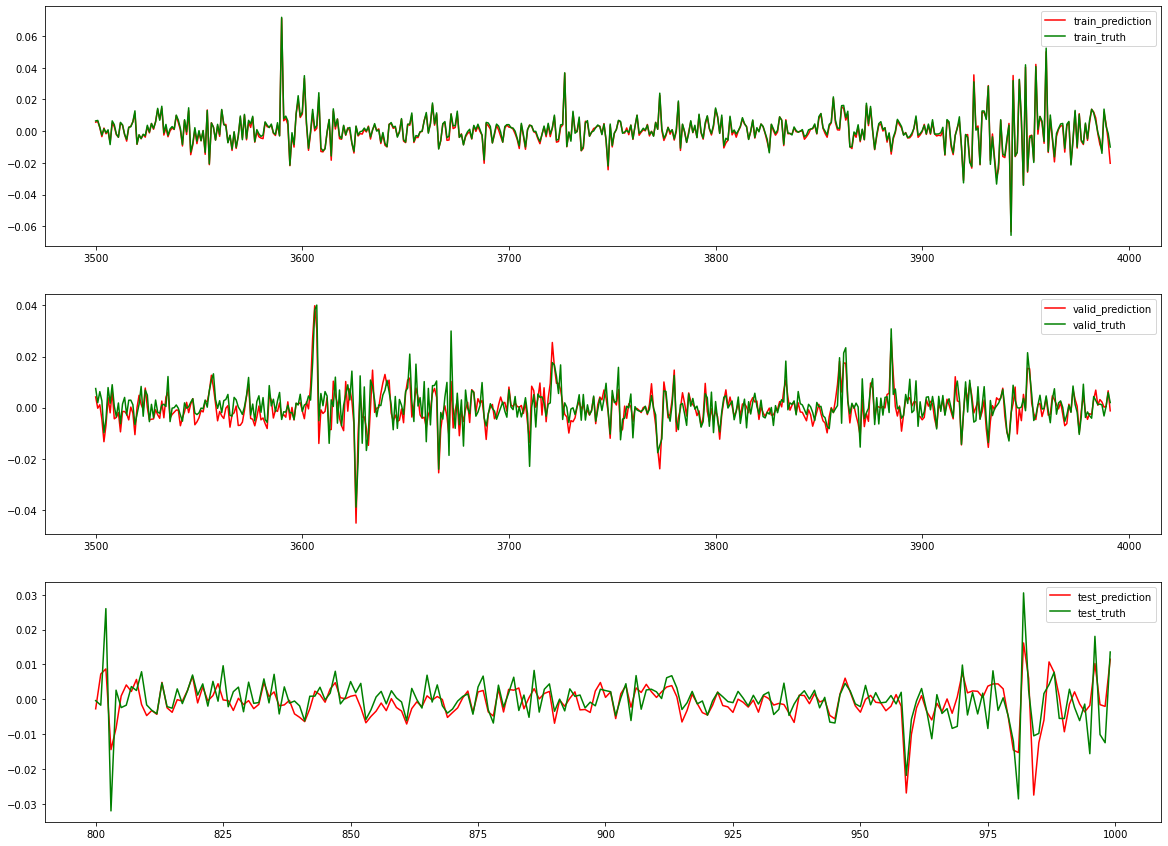

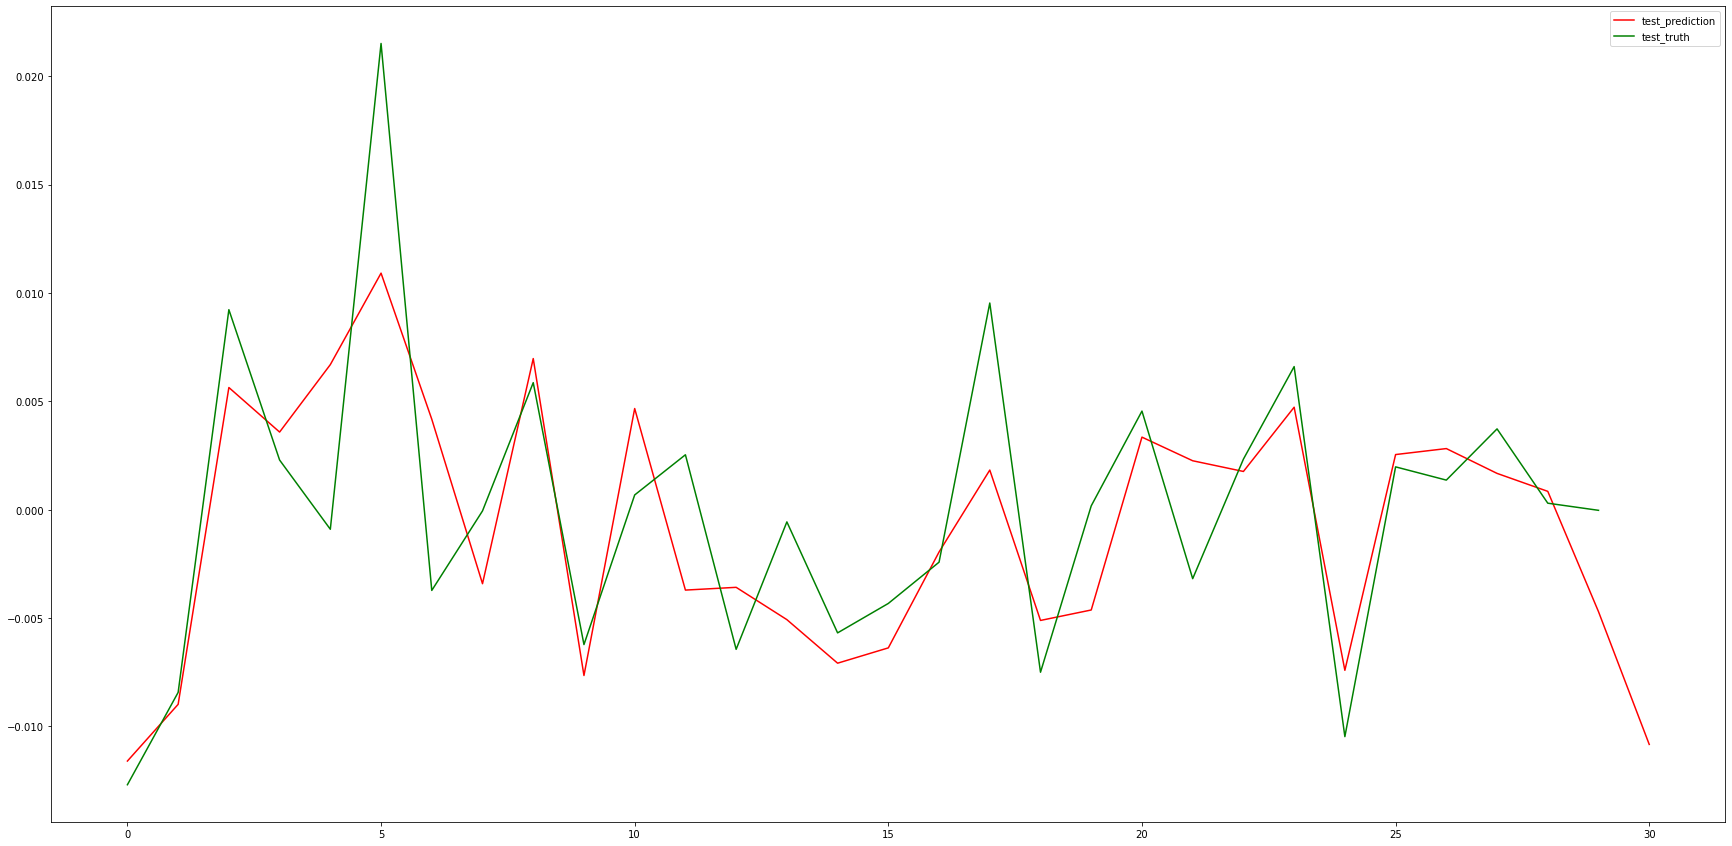

In [28]:
results =  history0.model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1] * 100)
print(history0.history.keys())
draw_result(history0, n_features, minmax)
input_data = dataset[-20:,:-1]
input_data = input_data.reshape(1,20,n_features)
input_data = np.append(X_test, input_data, axis=0)

real_prediction = pd.DataFrame((history0.model.predict(input_data[-31:]) * (minmax[n_features][1] - minmax[n_features][0])) + minmax[n_features][0])
y_tests = pd.DataFrame(y_test[-30:] * (minmax[n_features][1] - minmax[n_features][0]) + minmax[n_features][0])
plt.figure(figsize=(30,15))
plt.plot(real_prediction[1], 'red', label='test_prediction')
plt.plot(y_tests[1], 'g', label='test_truth')
plt.legend(loc='best')
print(f'{float(real_prediction[-1:][1]):.4f}')

In [29]:
history0.model.save(f'model_{str(0)} {n_features} _[acc{results[1]*100}].h5')

In [30]:
data = data60
period = 5
dataDecomposition = seasonal_decompose(data['Close'], 'multiplicative', period = period, extrapolate_trend=1)
data['seasonal'] = dataDecomposition.seasonal
data['trend'] = dataDecomposition.trend # data['Close'].ewm(span=5, adjust=False).mean()
data['detrend'] = dataDecomposition.resid # data['Close']/data['trend']/data['seasonal'] # dataDecomposition.resid

data = data[['Volume','EMA10','detrend', 'seasonal', 'trend', 'Close','return']]
data.columns = [['Volume','EMA10','detrend', 'seasonal', 'trend', 'Close','Change']]

dataset, minmax = normalize_data(data)
# choose a number of time steps
n_steps_in, n_steps_out = 20, 2
dataset = dataset.to_numpy()
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

train_len = int(len(X) * 0.4)
valid_len = int(len(X) * 0.4)
test_len = int(len(X) - train_len - valid_len)
print(train_len, valid_len, test_len, train_len + valid_len + test_len, len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_valid, y_valid = X[train_len:train_len + valid_len], y[train_len:train_len + valid_len]
X_test, y_test = X[-test_len:], y[-test_len:]
print(len(X_train), len(X_valid), len(X_test))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# [:0.5] [0.5:0.4] [-0.1]
print('n_steps ', n_steps_in, 'n_features', n_features)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', rmse])

model.summary()

3992 3992 1996 9980 9980
3992 3992 1996
n_steps  20 n_features 6
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 14, 64)            2752      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 10, 128)           41088     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 4, 128)            32896     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 2, 128)            0         
_______________________________________________________

In [25]:
# fit model
history1 = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        TensorBoard(log_dir="logs/fit/" + str(n_features)+' features '+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
                    ],
)

63/63 [==============================] - 1s 10ms/step - loss: 4.2022e-04 - accuracy: 0.7811 - mae: 0.0148 - rmse: 0.0166

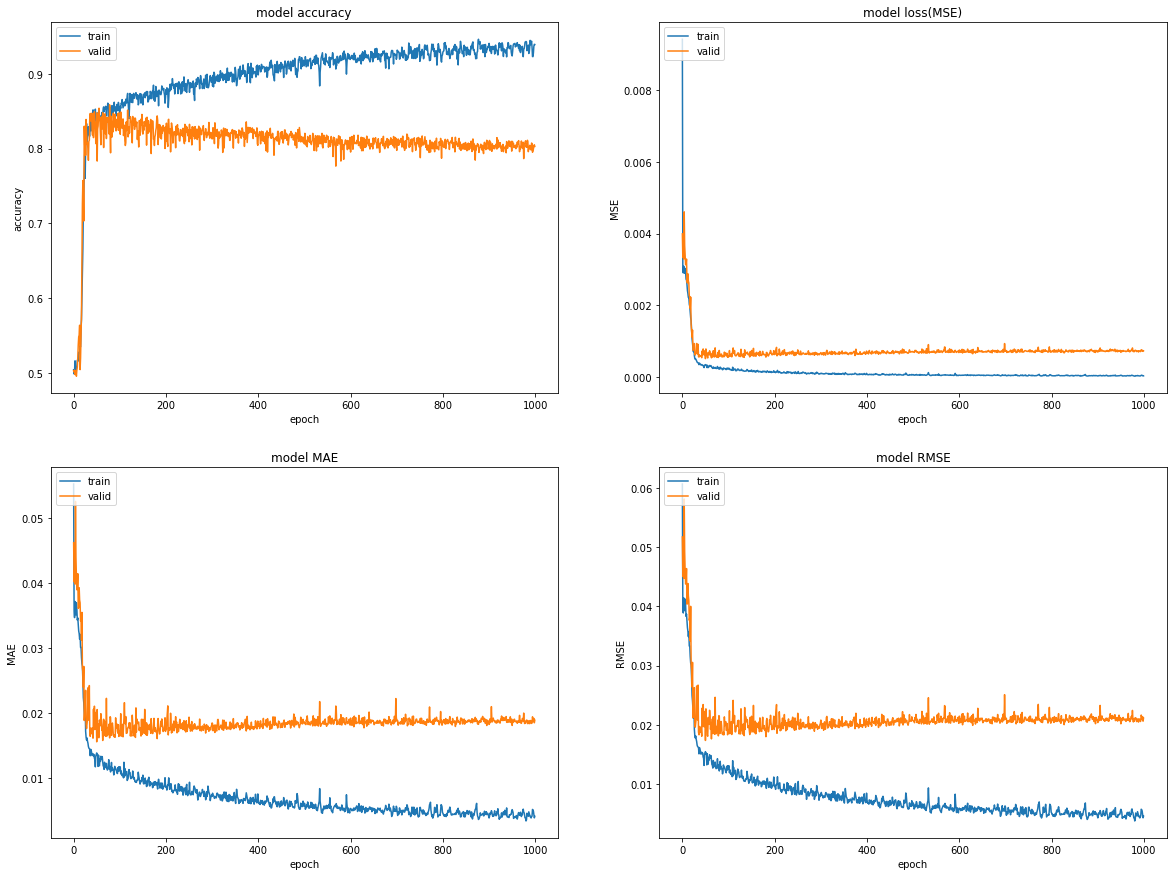

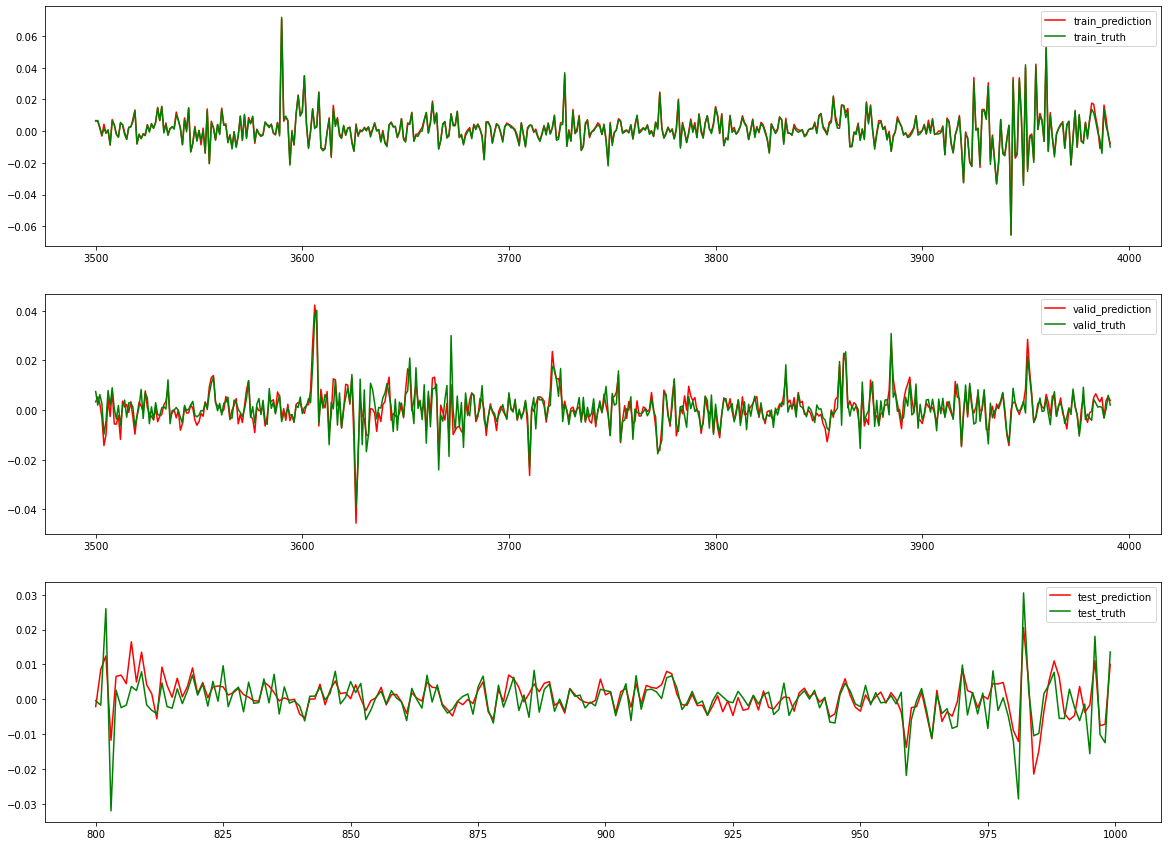

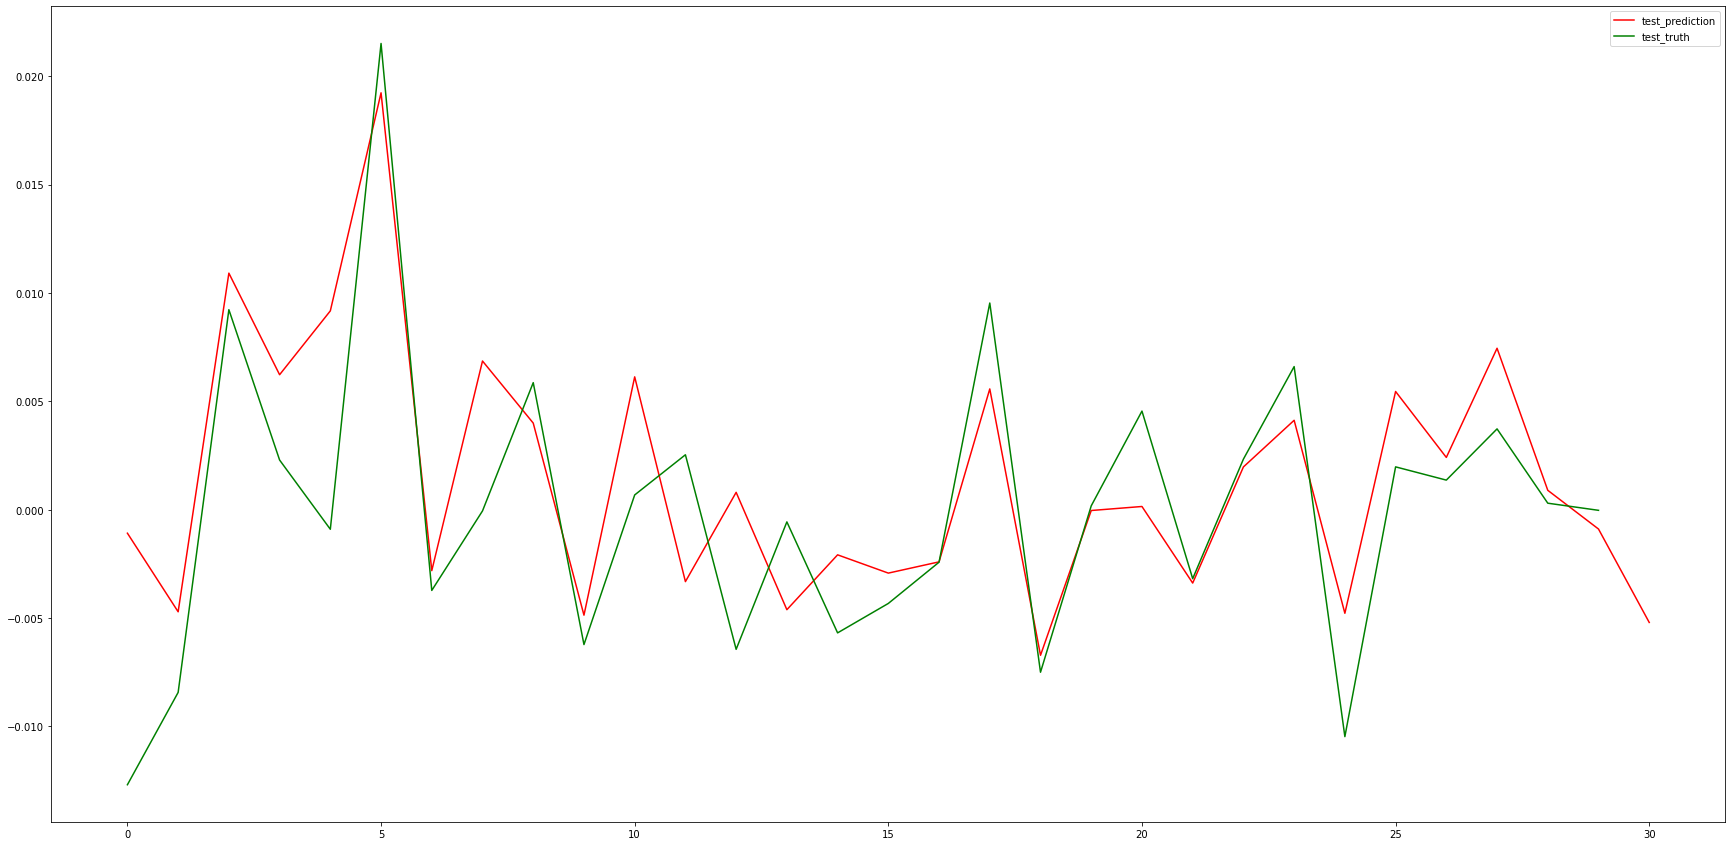

In [31]:
results =  history1.model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1] * 100)
print(history1.history.keys())
draw_result(history1, n_features, minmax)
input_data = dataset[-20:,:-1]
input_data = input_data.reshape(1,20,n_features)
input_data = np.append(X_test, input_data, axis=0)

real_prediction = pd.DataFrame((history1.model.predict(input_data[-31:]) * (minmax[n_features][1] - minmax[n_features][0])) + minmax[n_features][0])
y_tests = pd.DataFrame(y_test[-30:] * (minmax[n_features][1] - minmax[n_features][0]) + minmax[n_features][0])
plt.figure(figsize=(30,15))
plt.plot(real_prediction[1], 'red', label='test_prediction')
plt.plot(y_tests[1], 'g', label='test_truth')
plt.legend(loc='best')
print(f'{float(real_prediction[-1:][1]):.4f}')

In [32]:
history1.model.save(f'model_{str(1)} {n_features} _[acc{results[1]*100}].h5')

In [33]:
data = data60
period = 5
dataDecomposition = seasonal_decompose(data['Close'], 'multiplicative', period = period, extrapolate_trend=1)
data['seasonal'] = dataDecomposition.seasonal
data['trend'] = dataDecomposition.trend # data['Close'].ewm(span=5, adjust=False).mean()
data['detrend'] = dataDecomposition.resid # data['Close']/data['trend']/data['seasonal'] # dataDecomposition.resid

data = data[['Volume','EMA10', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','return']]
data.columns = [['Volume','EMA10', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','Change']]

dataset, minmax = normalize_data(data)
# choose a number of time steps
n_steps_in, n_steps_out = 20, 2
dataset = dataset.to_numpy()
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

train_len = int(len(X) * 0.4)
valid_len = int(len(X) * 0.4)
test_len = int(len(X) - train_len - valid_len)
print(train_len, valid_len, test_len, train_len + valid_len + test_len, len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_valid, y_valid = X[train_len:train_len + valid_len], y[train_len:train_len + valid_len]
X_test, y_test = X[-test_len:], y[-test_len:]
print(len(X_train), len(X_valid), len(X_test))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# [:0.5] [0.5:0.4] [-0.1]
print('n_steps ', n_steps_in, 'n_features', n_features)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', rmse])

model.summary()

3992 3992 1996 9980 9980
3992 3992 1996
n_steps  20 n_features 7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 14, 64)            3200      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 10, 128)           41088     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 4, 128)            32896     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 2, 128)            0         
_______________________________________________________

In [25]:
# fit model
history2 = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        TensorBoard(log_dir="logs/fit/" + str(n_features)+' features '+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
                    ],
)

63/63 [==============================] - 1s 8ms/step - loss: 3.4948e-04 - accuracy: 0.7951 - mae: 0.0136 - rmse: 0.0153

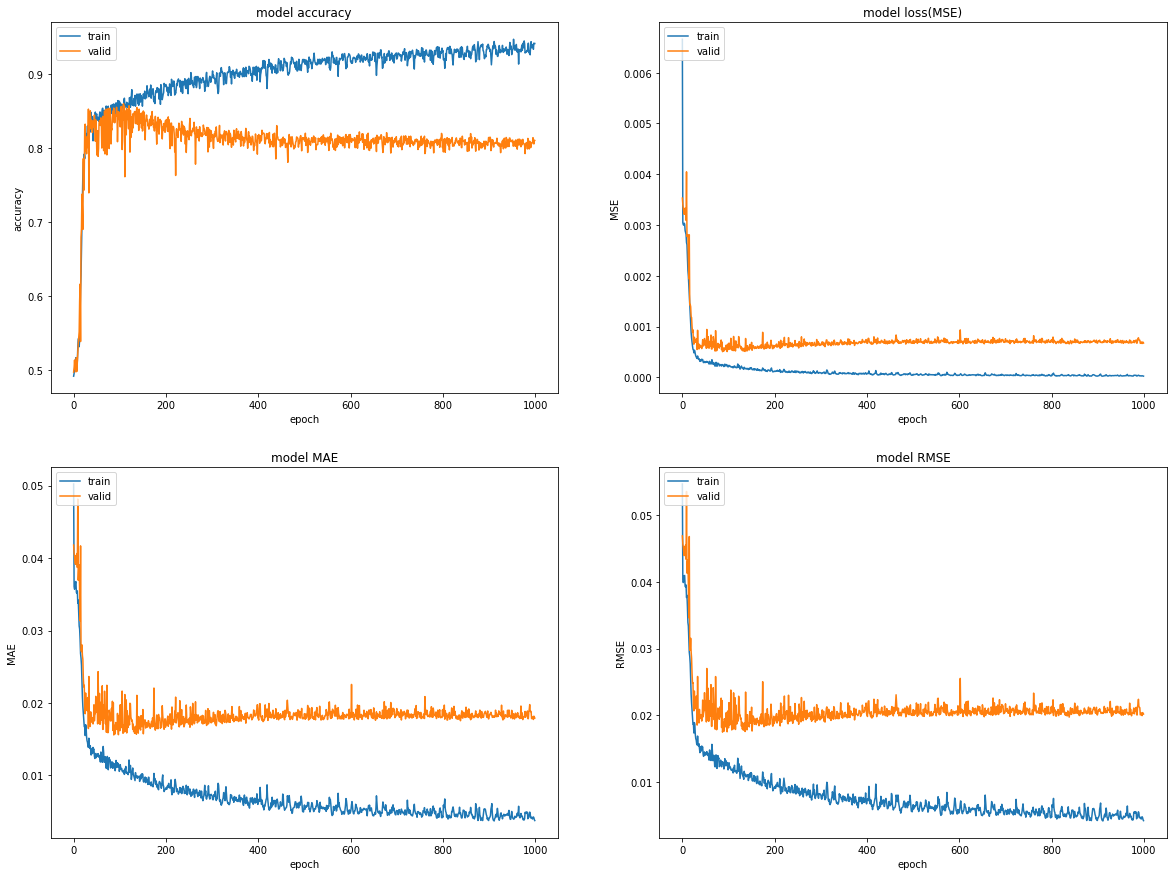

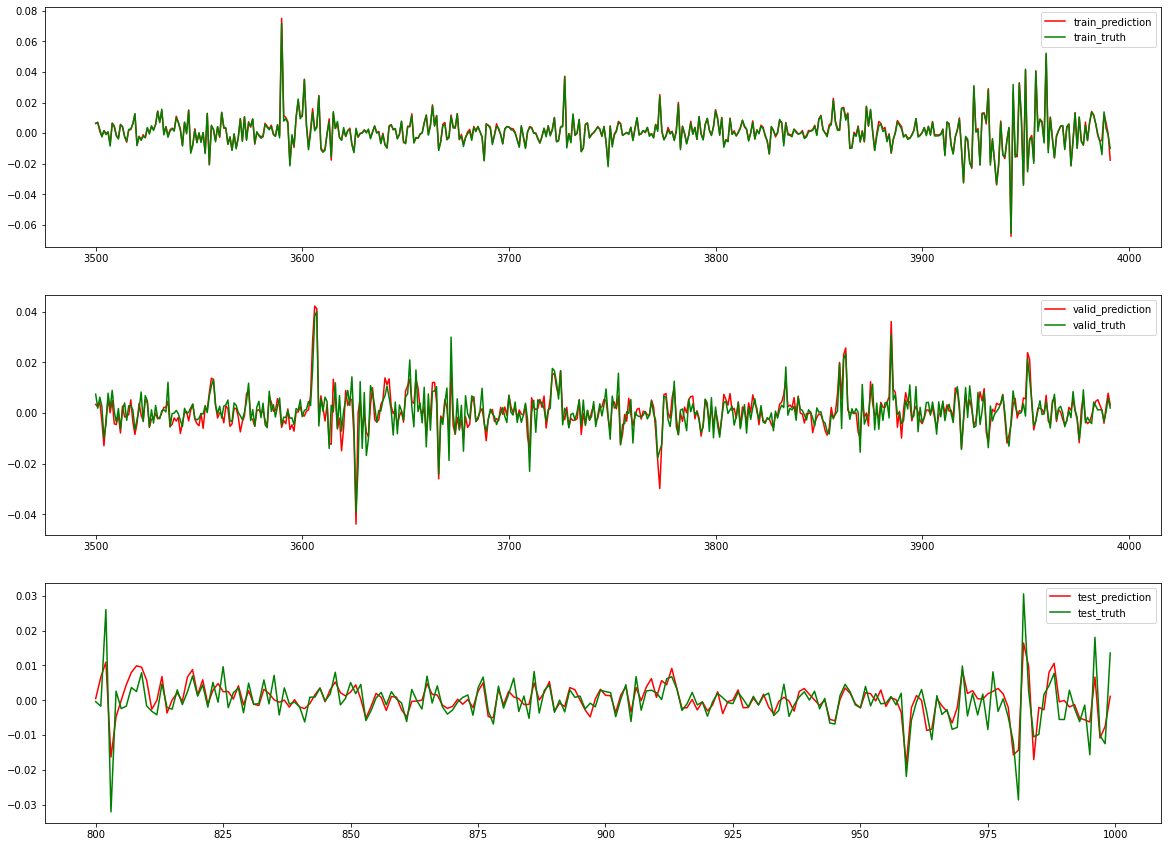

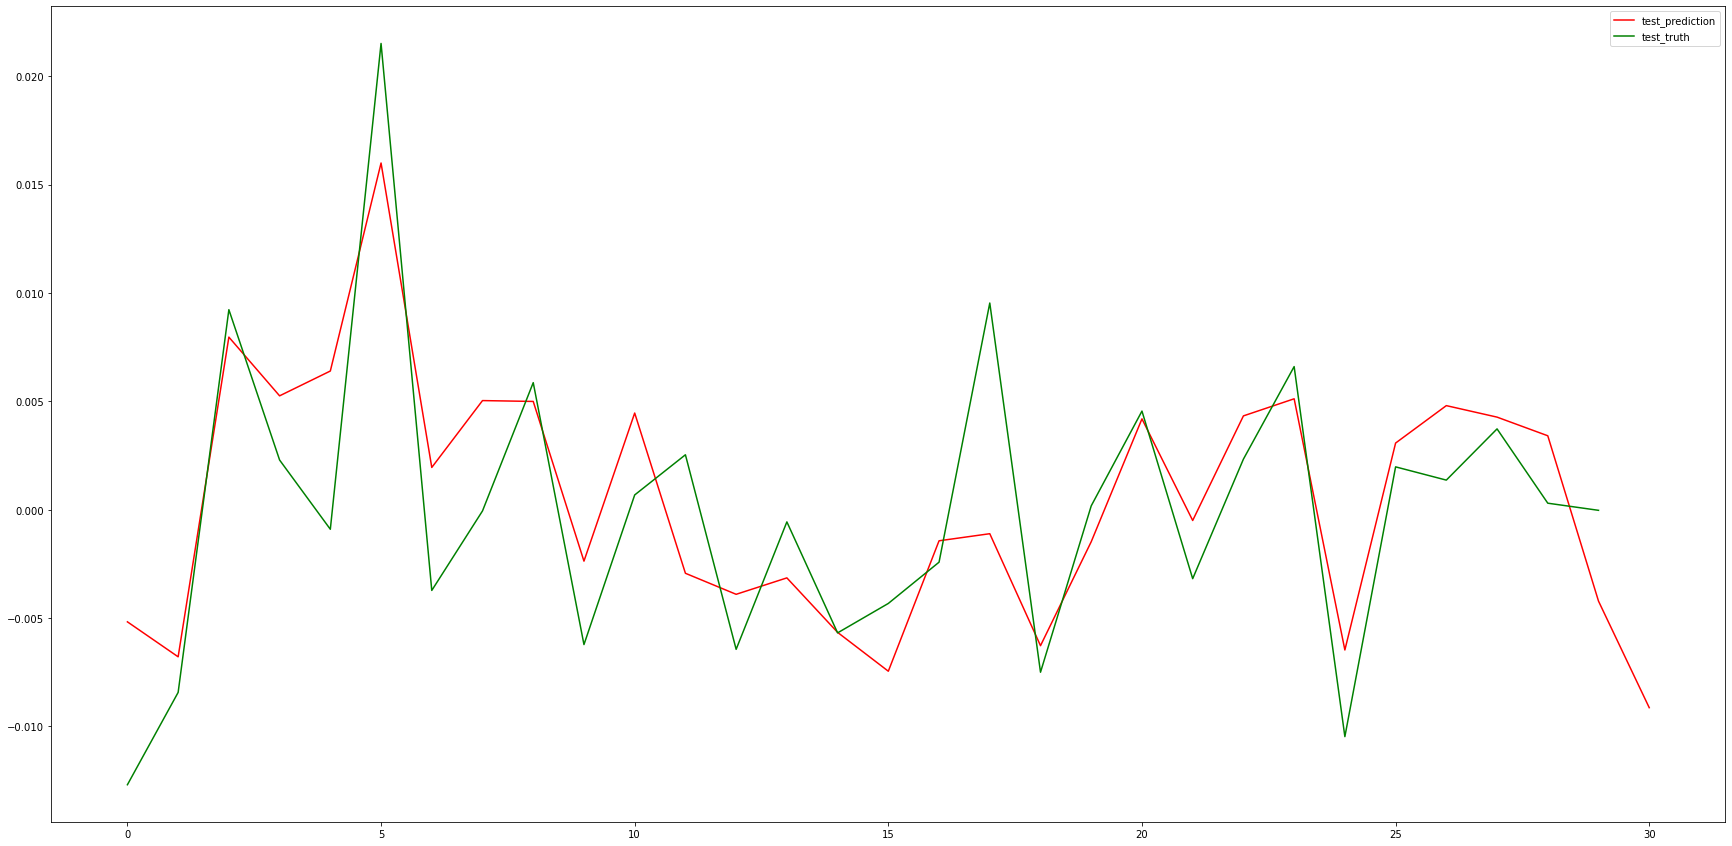

In [34]:
results =  history2.model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1] * 100)
print(history2.history.keys())
draw_result(history2, n_features, minmax)
input_data = dataset[-20:,:-1]
input_data = input_data.reshape(1,20,n_features)
input_data = np.append(X_test, input_data, axis=0)

real_prediction = pd.DataFrame((history2.model.predict(input_data[-31:]) * (minmax[n_features][1] - minmax[n_features][0])) + minmax[n_features][0])
y_tests = pd.DataFrame(y_test[-30:] * (minmax[n_features][1] - minmax[n_features][0]) + minmax[n_features][0])
plt.figure(figsize=(30,15))
plt.plot(real_prediction[1], 'red', label='test_prediction')
plt.plot(y_tests[1], 'g', label='test_truth')
plt.legend(loc='best')
print(f'{float(real_prediction[-1:][1]):.4f}')

In [35]:
history2.model.save(f'model_{str(2)} {n_features} _[acc{results[1]*100}].h5')

In [36]:
data = data60
period = 5
dataDecomposition = seasonal_decompose(data['Close'], 'multiplicative', period = period, extrapolate_trend=1)
data['seasonal'] = dataDecomposition.seasonal
data['trend'] = dataDecomposition.trend # data['Close'].ewm(span=5, adjust=False).mean()
data['detrend'] = dataDecomposition.resid # data['Close']/data['trend']/data['seasonal'] # dataDecomposition.resid

data = data[['Volume','EMA10','MFI', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','return']]
data.columns = [['Volume','EMA10','MFI', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','Change']]

dataset, minmax = normalize_data(data)
# choose a number of time steps
n_steps_in, n_steps_out = 20, 2
dataset = dataset.to_numpy()
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

train_len = int(len(X) * 0.4)
valid_len = int(len(X) * 0.4)
test_len = int(len(X) - train_len - valid_len)
print(train_len, valid_len, test_len, train_len + valid_len + test_len, len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_valid, y_valid = X[train_len:train_len + valid_len], y[train_len:train_len + valid_len]
X_test, y_test = X[-test_len:], y[-test_len:]
print(len(X_train), len(X_valid), len(X_test))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# [:0.5] [0.5:0.4] [-0.1]
print('n_steps ', n_steps_in, 'n_features', n_features)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', rmse])

model.summary()

3992 3992 1996 9980 9980
3992 3992 1996
n_steps  20 n_features 8
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 14, 64)            3648      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 10, 128)           41088     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 4, 128)            32896     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 2, 128)            0         
_______________________________________________________

In [25]:
# fit model
history3 = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        TensorBoard(log_dir="logs/fit/" + str(n_features)+' features '+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
                    ],
)

63/63 [==============================] - 0s 7ms/step - loss: 3.6873e-04 - accuracy: 0.7841 - mae: 0.0141 - rmse: 0.0157

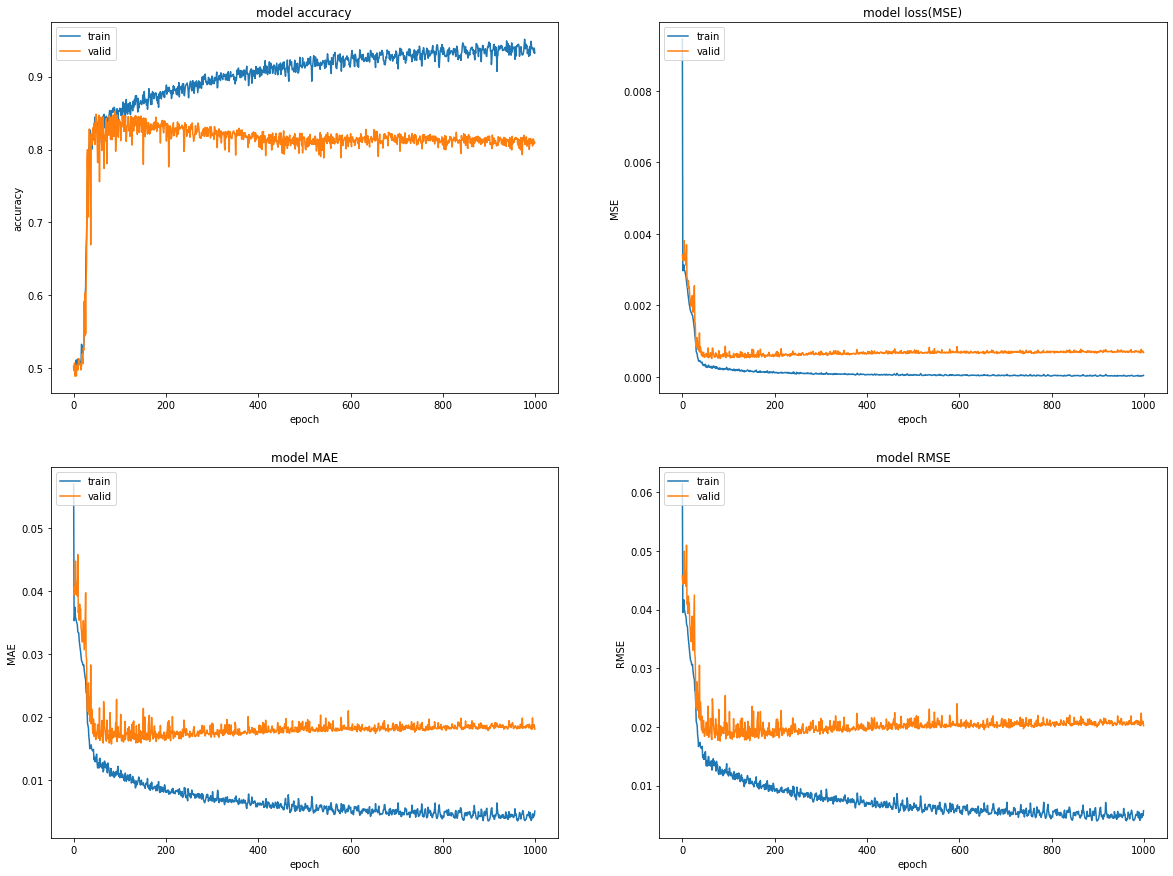

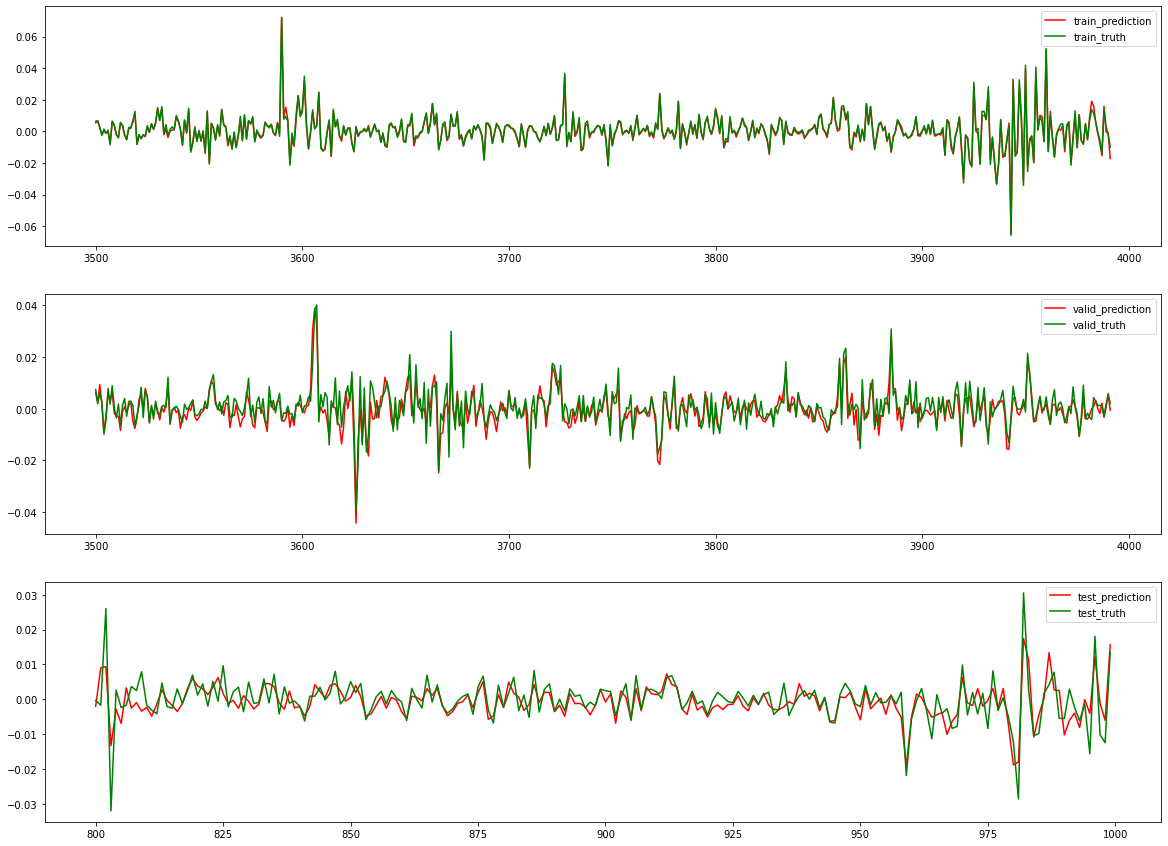

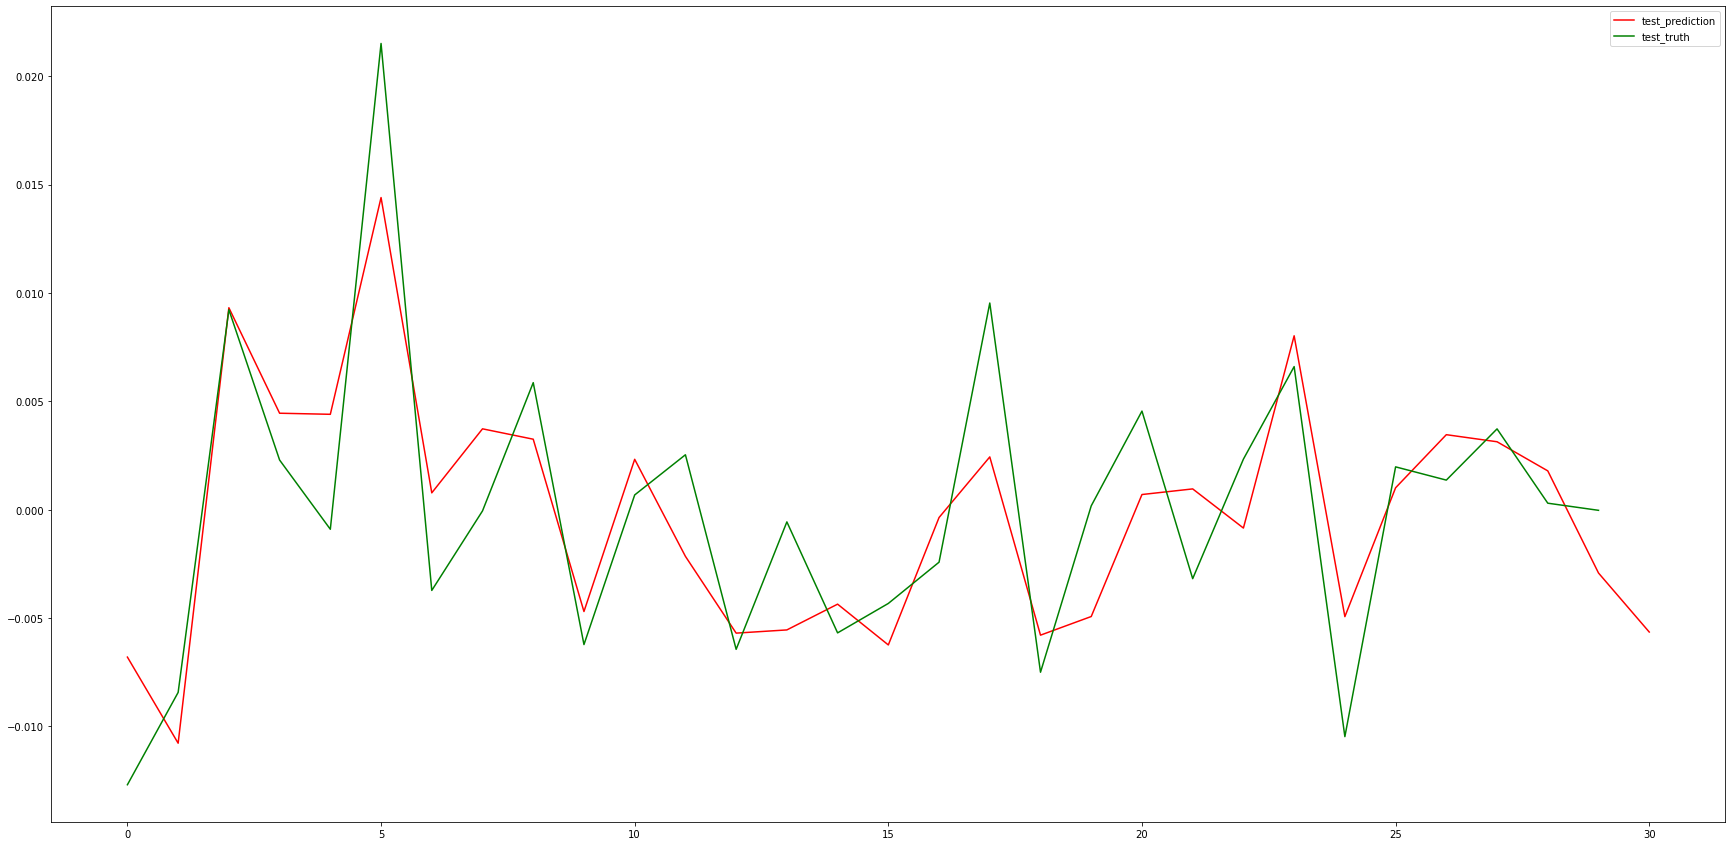

In [37]:
results =  history3.model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1] * 100)
print(history3.history.keys())
draw_result(history3, n_features, minmax)
input_data = dataset[-20:,:-1]
input_data = input_data.reshape(1,20,n_features)
input_data = np.append(X_test, input_data, axis=0)

real_prediction = pd.DataFrame((history3.model.predict(input_data[-31:]) * (minmax[n_features][1] - minmax[n_features][0])) + minmax[n_features][0])
y_tests = pd.DataFrame(y_test[-30:] * (minmax[n_features][1] - minmax[n_features][0]) + minmax[n_features][0])
plt.figure(figsize=(30,15))
plt.plot(real_prediction[1], 'red', label='test_prediction')
plt.plot(y_tests[1], 'g', label='test_truth')
plt.legend(loc='best')
print(f'{float(real_prediction[-1:][1]):.4f}')

In [38]:
history3.model.save(f'model_{str(3)} {n_features} _[acc{results[1]*100}].h5')

In [39]:
data = data60
period = 5
dataDecomposition = seasonal_decompose(data['Close'], 'multiplicative', period = period, extrapolate_trend=1)
data['seasonal'] = dataDecomposition.seasonal
data['trend'] = dataDecomposition.trend # data['Close'].ewm(span=5, adjust=False).mean()
data['detrend'] = dataDecomposition.resid # data['Close']/data['trend']/data['seasonal'] # dataDecomposition.resid

data = data[['Volume','EMA10','MFI', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','geomean2','geomean7','geomean12','return']]
data.columns = [['Volume','EMA10','MFI', 'detrend', 'seasonal', 'trend', 'Close','MACD-S','geomean2','geomean7','geomean12','Change']]

dataset, minmax = normalize_data(data)
# choose a number of time steps
n_steps_in, n_steps_out = 20, 2
dataset = dataset.to_numpy()
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

train_len = int(len(X) * 0.4)
valid_len = int(len(X) * 0.4)
test_len = int(len(X) - train_len - valid_len)
print(train_len, valid_len, test_len, train_len + valid_len + test_len, len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_valid, y_valid = X[train_len:train_len + valid_len], y[train_len:train_len + valid_len]
X_test, y_test = X[-test_len:], y[-test_len:]
print(len(X_train), len(X_valid), len(X_test))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# [:0.5] [0.5:0.4] [-0.1]
print('n_steps ', n_steps_in, 'n_features', n_features)

3992 3992 1996 9980 9980
3992 3992 1996
n_steps  20 n_features 11


In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', rmse])

model.summary()

In [25]:
# fit model
history4 = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        TensorBoard(log_dir="logs/fit/" + str(n_features)+' features '+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
                    ],
)

63/63 [==============================] - 0s 7ms/step - loss: 5.9746e-05 - accuracy: 0.9218 - mae: 0.0053 - rmse: 0.0060

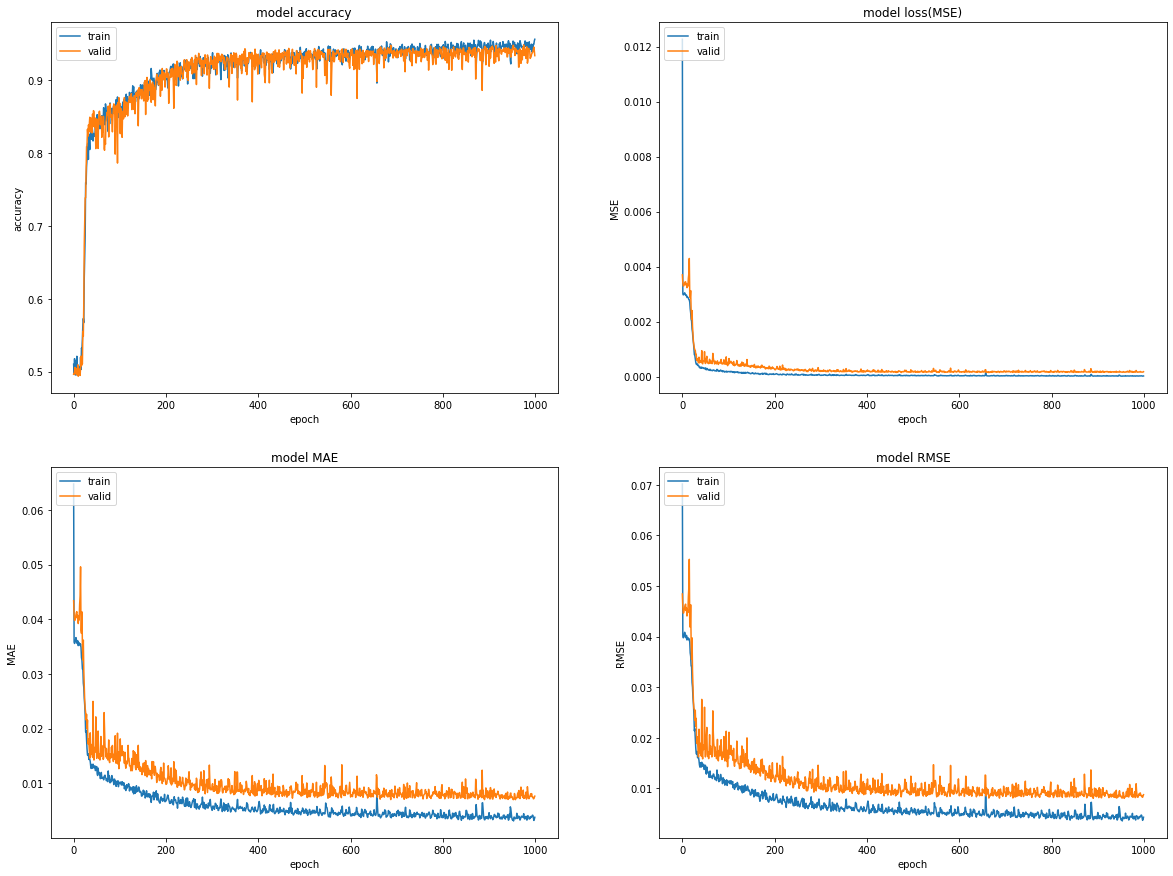

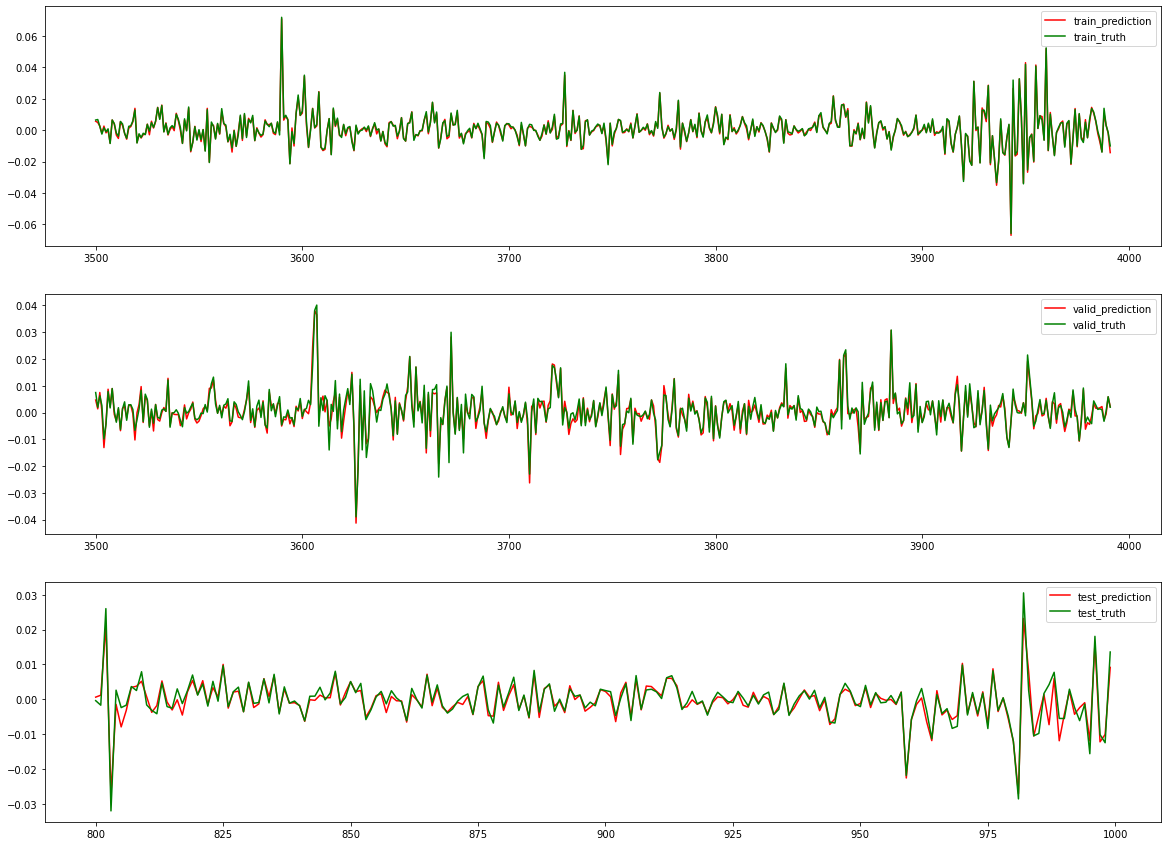

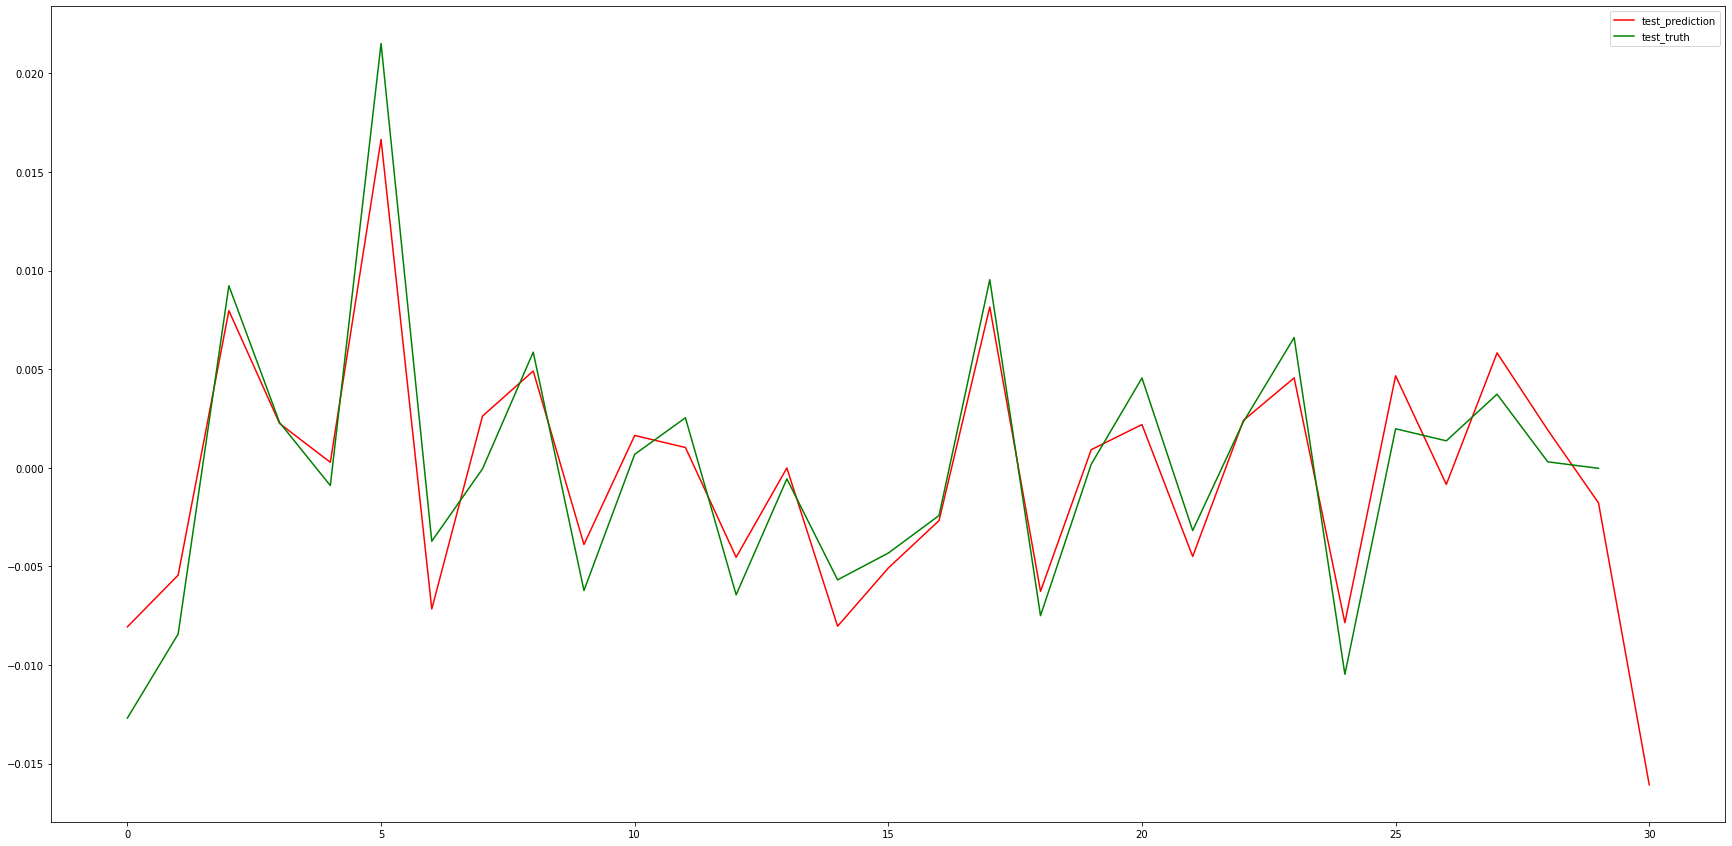

In [40]:
results =  history4.model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1] * 100)
print(history4.history.keys())
draw_result(history4, n_features, minmax)
input_data = dataset[-20:,:-1]
input_data = input_data.reshape(1,20,n_features)
input_data = np.append(X_test, input_data, axis=0)

real_prediction = pd.DataFrame((history4.model.predict(input_data[-31:]) * (minmax[n_features][1] - minmax[n_features][0])) + minmax[n_features][0])
y_tests = pd.DataFrame(y_test[-30:] * (minmax[n_features][1] - minmax[n_features][0]) + minmax[n_features][0])
plt.figure(figsize=(30,15))
plt.plot(real_prediction[1], 'red', label='test_prediction')
plt.plot(y_tests[1], 'g', label='test_truth')
plt.legend(loc='best')
print(f'{float(real_prediction[-1:][1]):.4f}')

In [41]:
history4.model.save(f'model_{str(4)} {n_features} _[acc{results[1]*100}].h5')